In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [4]:
train.chas = train.chas.astype('category')

In [5]:
train.shape, test.shape

((333, 15), (173, 14))

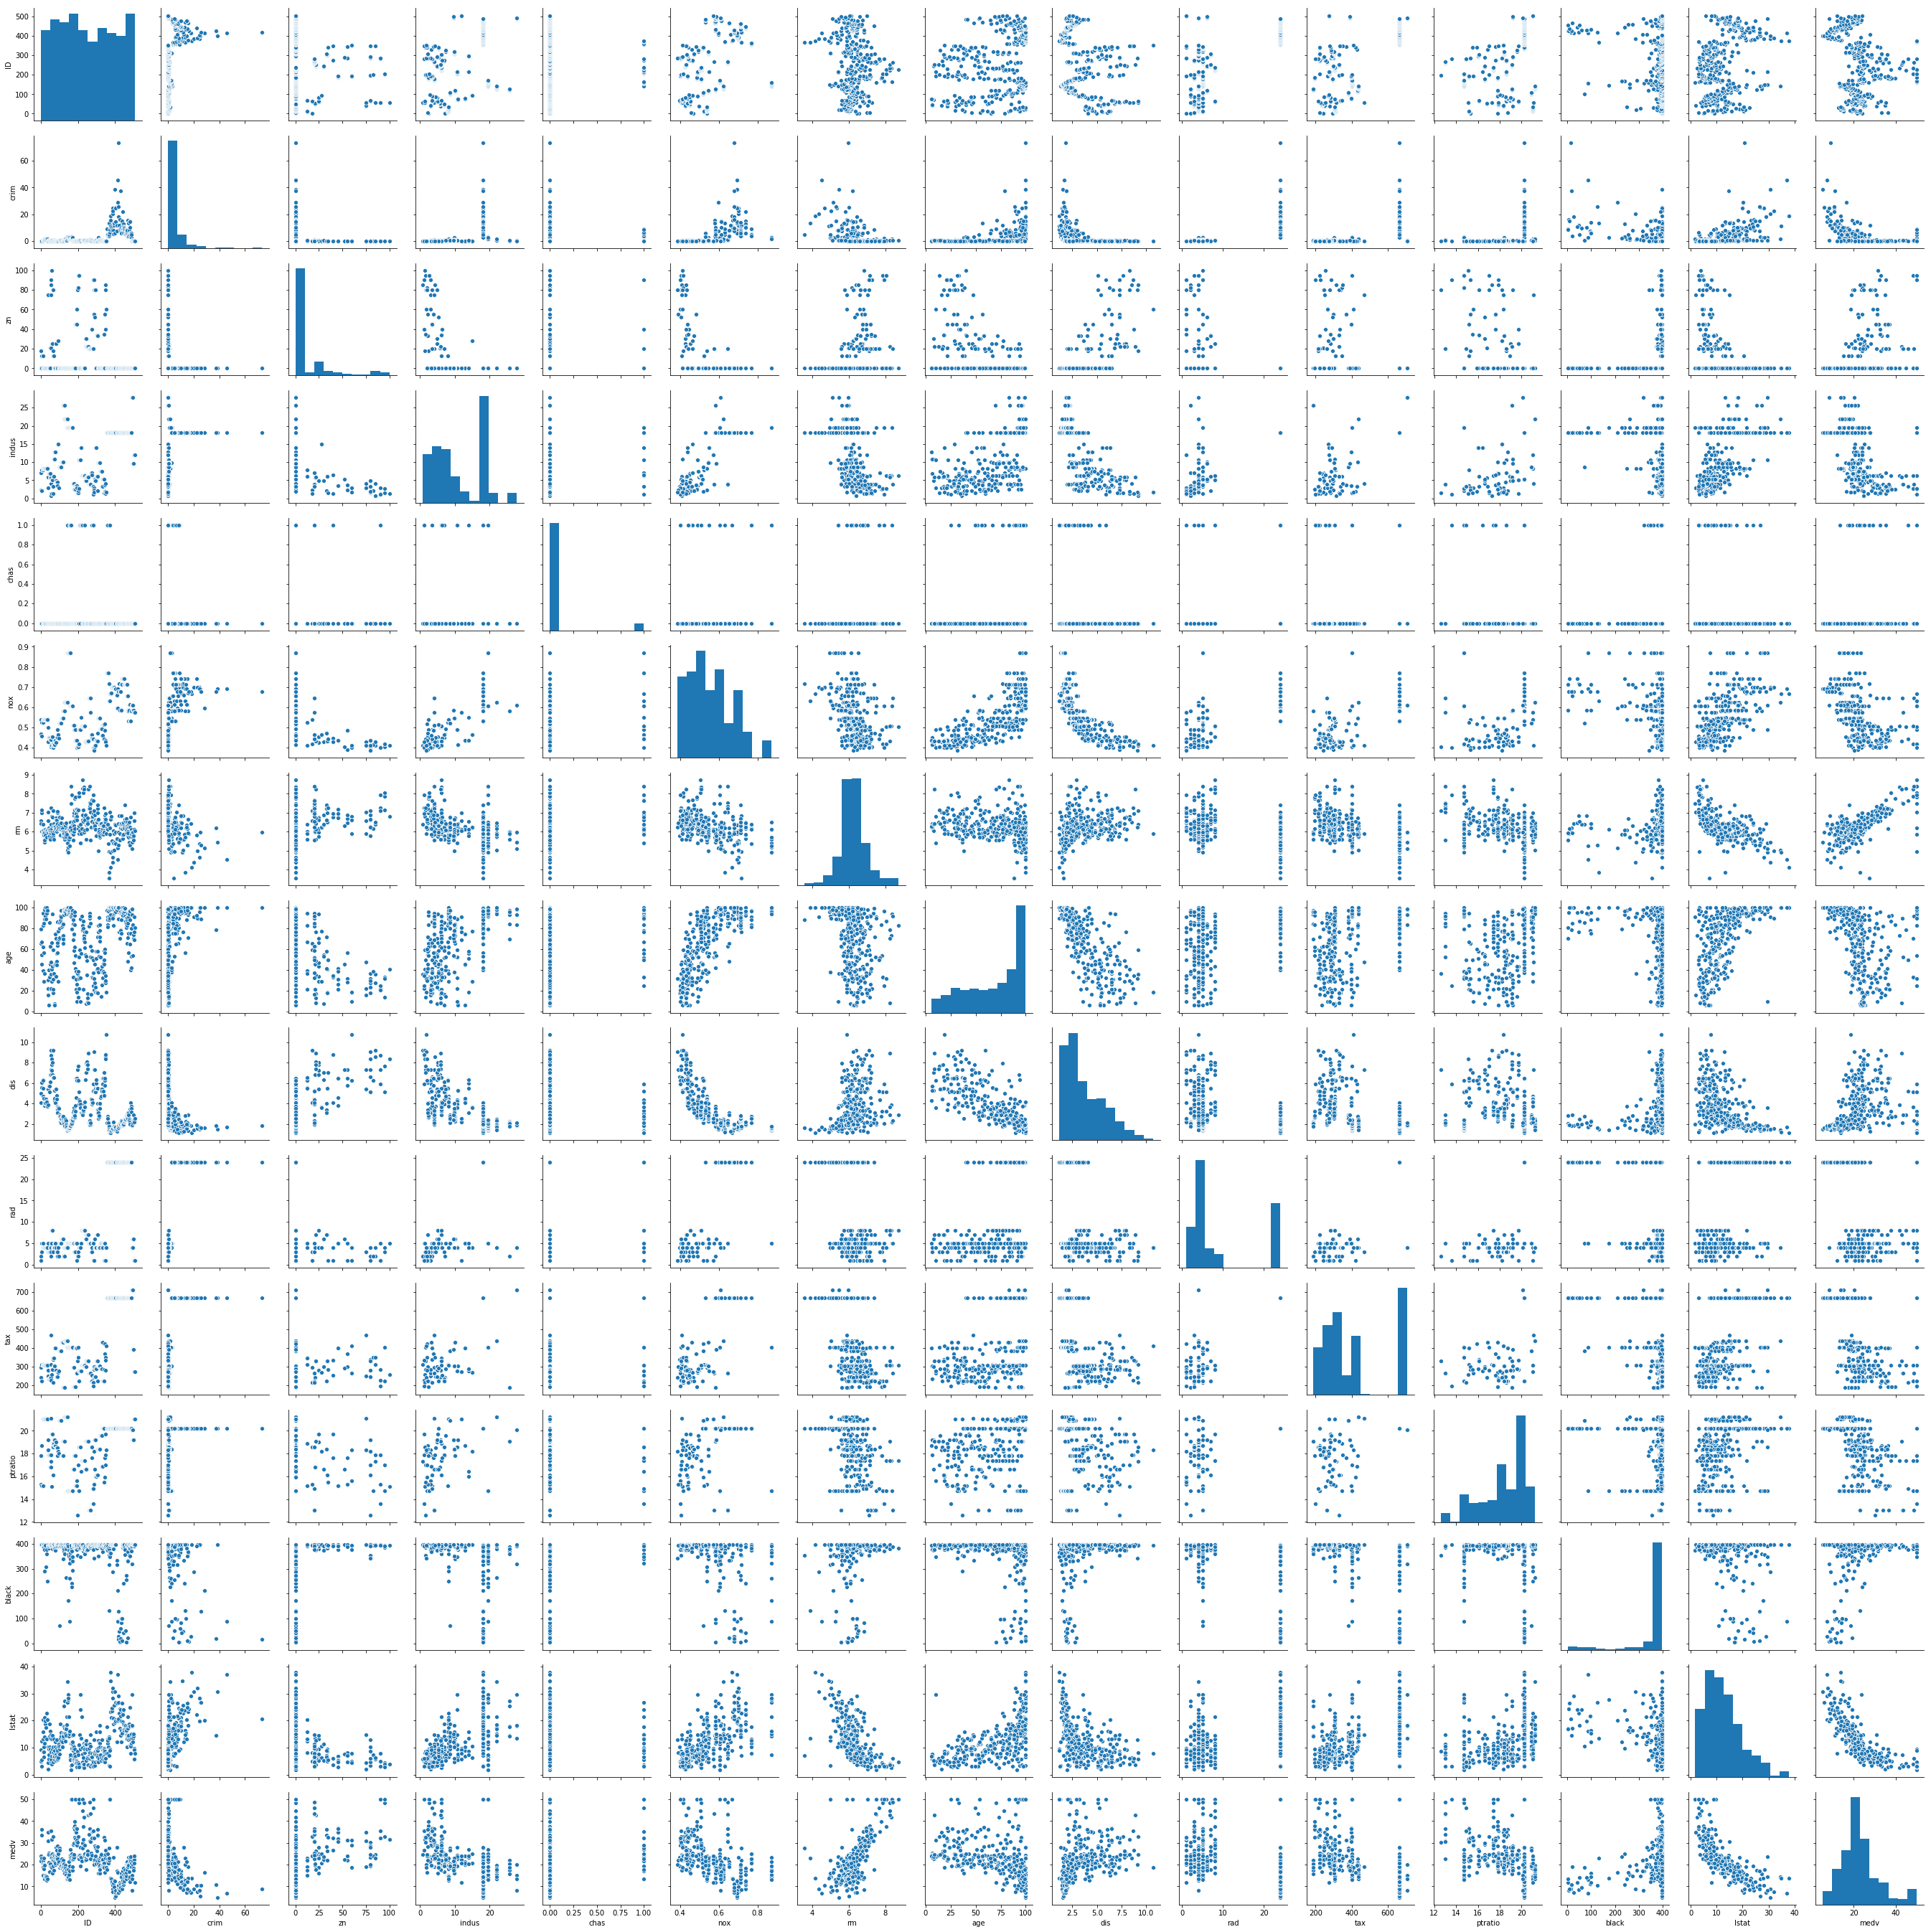

In [6]:
sns.pairplot(train)

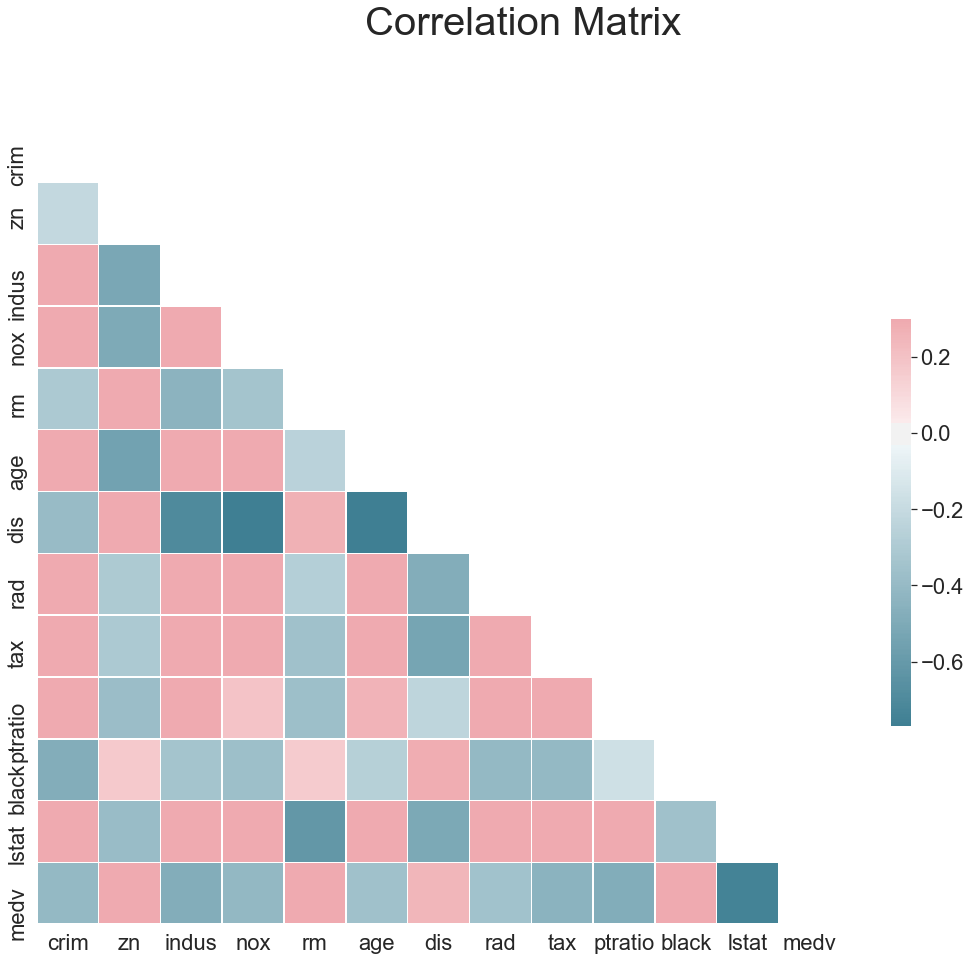

In [7]:
## Correlation Matrix
sns.set(style="white", font_scale=2)

# Compute the correlation matrix
corr = train.drop("ID",axis=1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))
f.suptitle("Correlation Matrix", fontsize = 40)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

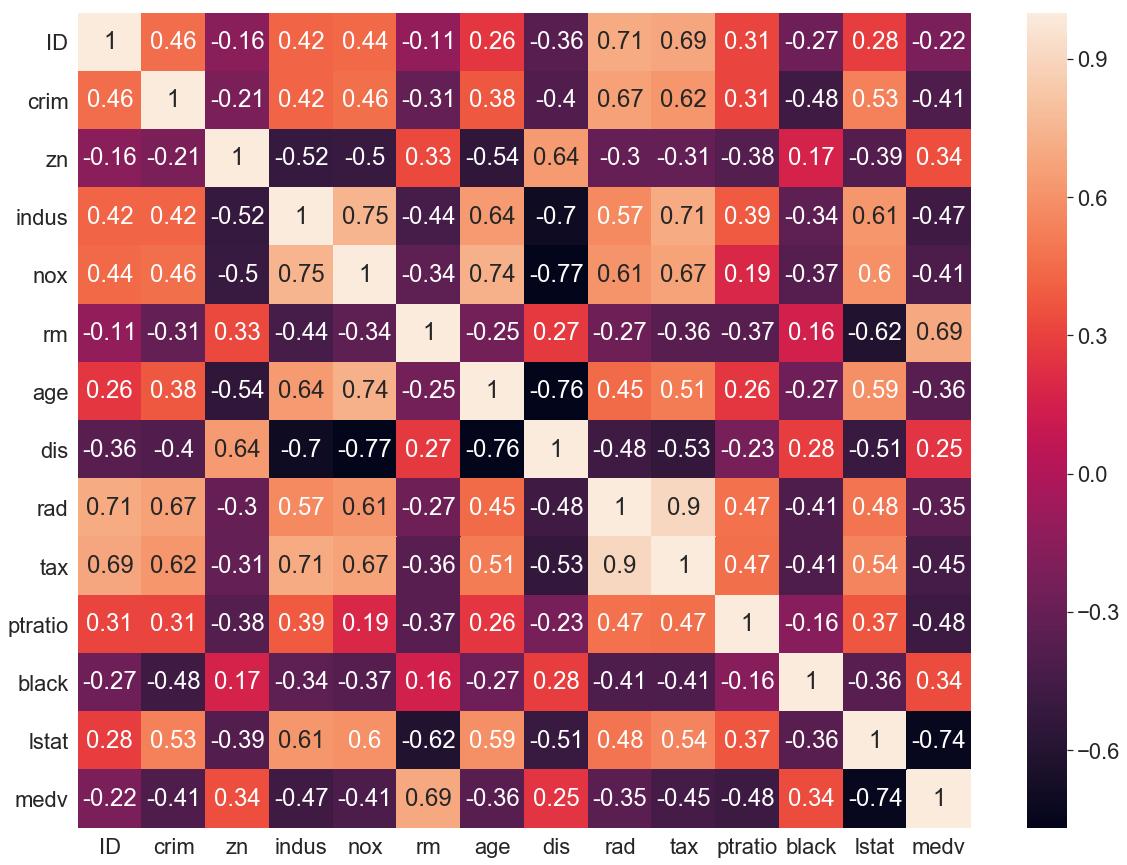

In [8]:
plt.subplots(figsize=(20, 15))
sns.heatmap(train.corr(), annot=True)

In [9]:
X1 = train.drop(["ID"],axis=1)
X2 = test.drop(["ID"],axis=1)

X = X1.iloc[:,:-1]
y = X1.iloc[:,-1]
X_cv = X2

# Dummy variables
X = pd.get_dummies(X, drop_first=True)
X_cv = pd.get_dummies(X_cv, drop_first=True)

In [10]:
# Spliting data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [11]:
# feature scaling
from  sklearn.preprocessing  import StandardScaler

slc= StandardScaler()
X_train = slc.fit_transform(X_train)
X_cv = slc.transform(X_cv)
X_test = slc.transform(X_test)

r2 = {}
rmse ={}

In [16]:
# Test options and evaluation metric
num_folds = 10
seed = 0
scoring = 'neg_mean_squared_error'

In [17]:
# Spot-Check Algorithms
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -26.799867 (9.379740)
LASSO: -32.006428 (14.462336)
EN: -33.441108 (17.222791)
KNN: -26.005824 (16.001115)
CART: -33.570868 (22.178703)
SVR: -37.329598 (22.905158)


In [18]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error

ensembles = []
ensembles.append(('AB', AdaBoostRegressor()))
ensembles.append(('GBM', GradientBoostingRegressor()))
ensembles.append(('ET', ExtraTreesRegressor()))
ensembles.append(('RF', RandomForestRegressor()))

# evaluate each ensemble model in turn
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


AB: -20.067320 (13.411727)
GBM: -13.626131 (10.818715)
ET: -13.815682 (6.908539)
RF: -17.062815 (13.252289)


In [31]:
from sklearn.grid_search import GridSearchCV

num_folds = 10
seed = 0
scoring = 'neg_mean_squared_error'

model = GradientBoostingRegressor(random_state=seed)

params = {'n_estimators':list(range(50,500,50))}

grid_search = GridSearchCV(estimator = model ,param_grid = params,scoring=scoring ,cv =num_folds, verbose = 4) 
grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV] n_estimators=50 .................................................
[CV] ....................... n_estimators=50, score=-6.986247 -   0.0s
[CV] n_estimators=50 .................................................
[CV] ....................... n_estimators=50, score=-8.820095 -   0.0s
[CV] n_estimators=50 .................................................
[CV] ....................... n_estimators=50, score=-9.152009 -   0.0s
[CV] n_estimators=50 .................................................
[CV] ...................... n_estimators=50, score=-12.590091 -   0.0s
[CV] n_estimators=50 .................................................
[CV] ...................... n_estimators=50, score=-10.517258 -   0.0s
[CV] n_estimators=50 .................................................
[CV] ...................... n_estimators=50, score=-24.944398 -   0.0s
[CV] n_estimators=50 .................................................
[CV] ...........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


[CV] ...................... n_estimators=100, score=-8.201228 -   0.0s
[CV] n_estimators=100 ................................................
[CV] ...................... n_estimators=100, score=-8.795205 -   0.0s
[CV] n_estimators=100 ................................................
[CV] ..................... n_estimators=100, score=-13.181286 -   0.0s
[CV] n_estimators=100 ................................................
[CV] ..................... n_estimators=100, score=-10.249929 -   0.0s
[CV] n_estimators=100 ................................................
[CV] ..................... n_estimators=100, score=-24.087311 -   0.0s
[CV] n_estimators=100 ................................................
[CV] ...................... n_estimators=100, score=-9.087946 -   0.0s
[CV] n_estimators=100 ................................................
[CV] ..................... n_estimators=100, score=-10.952295 -   0.0s
[CV] n_estimators=100 ................................................
[CV] .

[CV] ...................... n_estimators=400, score=-7.338909 -   0.0s
[CV] n_estimators=400 ................................................
[CV] ...................... n_estimators=400, score=-7.913245 -   0.0s
[CV] n_estimators=400 ................................................
[CV] ...................... n_estimators=400, score=-9.632532 -   0.0s
[CV] n_estimators=400 ................................................
[CV] ..................... n_estimators=400, score=-13.296508 -   0.0s
[CV] n_estimators=400 ................................................
[CV] ..................... n_estimators=400, score=-10.594130 -   0.0s
[CV] n_estimators=400 ................................................
[CV] ..................... n_estimators=400, score=-23.219595 -   0.0s
[CV] n_estimators=400 ................................................
[CV] ...................... n_estimators=400, score=-9.133608 -   0.0s
[CV] n_estimators=400 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    6.1s finished


In [58]:
grid_predictions = grid_search.predict(X_test)
rmse['rfr_gridsearch'] = np.sqrt(mean_squared_error(y_test, grid_predictions))
r2['rfr_gridsearch'] = r2_score(y_test,grid_predictions)

In [62]:
final_predictions = grid_search.predict(X_cv)

In [66]:
submit = pd.read_csv("submission_example.csv")

In [68]:
submit.medv = final_predictions

In [69]:
submit.to_csv("my_submission.csv")

## Random Forest Regression with GridSearch is best